# Проект: Обучение с учителем: качество модели

## Описание

***Описание исследования:*** интернет-магазин «В один клик» продает широкий ассортимент товаров. Анализ данных показал снижение активности постоянных клиентов, несмотря на привлечение новых. Руководство поручило отделу цифровых технологий разработать решение для повышения покупательской активности постоянных клиентов.

***Цель исследования:*** разработать решение и дать рекомендации для персонализации предложений, направленное на увеличение покупательской активности постоянных клиентов интернет-магазина

___
Главные задачи исследования: 
 - Разработать модель, которая предскажет вероятность снижения покупательской активности
 - Выделите сегменты покупателей, проанализировать и дать необходимые рекомендации
 
 
Данное исследование разделим на несколько частей, которые будут выполнены для каждой задачи, выделим этапы:

***Изучение общей информации,*** в которой мы загрузим нужные библиотеки и проведем предварительное знакомство с данными 

***Подготовка данных.*** В данной части мы проверим и приведем данные к оптимальным форматам, обрабатаем дубликаты и пропуски.

***Исследовательский анализ и поиск аномалий.*** Проверим все признаки каждого датасета на предмет аномалий и сделаем выводы на основе распределения признаков

***Проведение корреляционного анализа.*** Посмотрим как между собой коррелируют признаки и проверим на мультиколлинеарность

***Построение модели*** для решения поставленной задачи и оценки качества 

***Формирование итогового вывода.***

___
***Исходные данные.***
```market_file.csv```
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
 - id — номер покупателя в корпоративной базе данных.
 - Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
 - Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
 - Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
 - Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
 - Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
 - Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
 - Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
 - Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
 - Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
 - Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
 - Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
 - Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

```market_money.csv```
Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
 - id — номер покупателя в корпоративной базе данных.
 - Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
 - Выручка — сумма выручки за период.
 
```market_time.csv```
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
 - id — номер покупателя в корпоративной базе данных.
 - Период — название периода, во время которого зафиксировано общее время.
 - минут — значение времени, проведённого на сайте, в минутах.
 
```money.csv```
Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
 - id — номер покупателя в корпоративной базе данных.
 - Прибыль — значение прибыли.


## Загрузка данных

In [66]:
!pip install scikit-learn==1.4.0 
!pip install shap 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import shap

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, StandardScaler,
                                   MinMaxScaler, RobustScaler)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix

from scipy.stats import pearsonr

from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [67]:
market_file = pd.read_csv('market_file.csv')
market_money = pd.read_csv('market_money.csv')
market_time = pd.read_csv('market_time.csv')
money = pd.read_csv('money.csv', sep=";", decimal=",")

In [68]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [69]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [70]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [71]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Итог загрузки данных данных:

 - Данные загружены
 - Данные во всех столбцах соответствую описанию
 - Принято решение оставить кириллицу
 - Названия столбцов написаны по-разному, что усложняет чтение и может усложнить работу в будущем 

##  Предобработка данных

In [72]:
#создадим функцию для проверки данных в датафреймах на пропуски и дубли
def df_info(df):
    print(df.info())
    print()
    print(f"Количество очевидных дубликатов = {df.duplicated().sum()}")
    print()
    print(f"Количество пропусков = {df.isna().sum()}")    

#создадим функцию для замены заглавных букв на строчные и пробелов на подчеркивание
def format_column_names(df):
    df.columns = [col.lower().replace(" ", "_") for col in df.columns]
    return df

### Данные о поведении покупателей

In [73]:
format_column_names(market_file)
df_info(market_file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [74]:
#определим категориальные значения по которым будем искать дубликаты
columns_to_check = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

for column in columns_to_check:
    unique_values = market_file[column].unique()
    print(f"Уникальные значения в столбце '{column}': {unique_values}")

Уникальные значения в столбце 'покупательская_активность': ['Снизилась' 'Прежний уровень']
Уникальные значения в столбце 'тип_сервиса': ['премиум' 'стандартт' 'стандарт']
Уникальные значения в столбце 'разрешить_сообщать': ['да' 'нет']
Уникальные значения в столбце 'популярная_категория': ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [75]:
#приведем в один формат похожие названия в столбцах
market_file['тип_сервиса'] = market_file['тип_сервиса'].str.replace('стандартт', 'стандарт')

Данные в хорошем состоянии, исправлена опечатка в столбце **Тип сервиса**

### Данные о выручке 

In [76]:
format_column_names(market_money)
df_info(market_money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None

Количество очевидных дубликатов = 0

Количество пропусков = id         0
период     0
выручка    0
dtype: int64


In [77]:
market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

**препредыдущий_месяц** звучит диковато, но понятно, что тут подразумевается позапрошлый месяц, оставим так. В остальном к данным претензий нет

### Данные о времени, проведенное на сайте

In [78]:
format_column_names(market_time)
df_info(market_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None

Количество очевидных дубликатов = 0

Количество пропусков = id        0
период    0
минут     0
dtype: int64


In [79]:
market_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [80]:
#исправим опечатку
market_time['период'] = market_time['период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')

Данные в хорошем состоянии, исправлена опечатка в столбце **Период**

### Данные о прибыли за последние 3 месяца 

In [81]:
format_column_names(money)
df_info(money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None

Количество очевидных дубликатов = 0

Количество пропусков = id         0
прибыль    0
dtype: int64


Претензий нет

Итог загрузки предобработки данных:
 - Во всех таблицах отсутствуют пропуски
 - Типы данных в корректном формате
 - Явных дубликатов не обнаружено
 - В ```market_file``` удалены неявные дубликаты
 - Исправлены опечатки
 - Названия стобцов приведены к змеиному регистру, но с оставленной кириллицей 

## Исследовательский анализ данных

In [82]:
#создадим универсальную функцию для визуализации данных в зависимости от типа
#для количественных - боксплот и гистограмму, для качественных - пирог

def plot_data_visualization(df, col_name):
    if df[col_name].dtype in ['int64', 'float64']:
        plt.figure(figsize=(12, 5))
        df[col_name].plot(kind='box')
        plt.title(f'Боксплот для {col_name}')
        plt.show()
    
        plt.figure(figsize=(12, 5))
        df[col_name].plot(kind='hist', bins=30)
        plt.title(f'Гистограмма для {col_name}')
        plt.xlabel(col_name)
        plt.ylabel('Частота')
        plt.show()
    else:
        plt.figure(figsize=(12, 5))
        counts = df[col_name].value_counts()
        counts.plot(kind='pie', autopct='%1.1f%%')
        plt.title(f'Соотношение {col_name}')
        plt.ylabel('')
        plt.show()

#создадим функцию для выведения первых строк датафрейма и описания количественных показателей
def explore_df(df):
    display(df.head())
    print()
    display(df.describe())

### Исследование поведения покупателей

In [83]:
explore_df(market_file)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Данные выглядят приемлемо, ярких аномалий не наблюдается

#### Среднемесячное значение маркетинговых коммуникаций

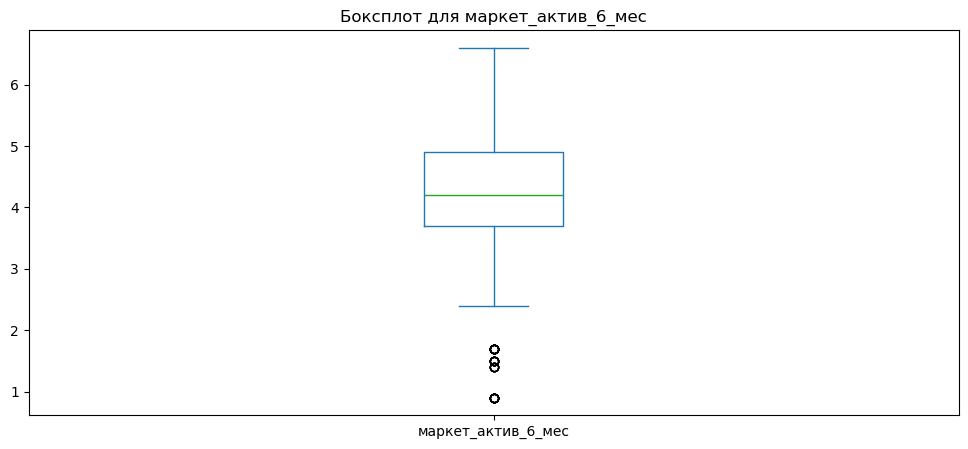

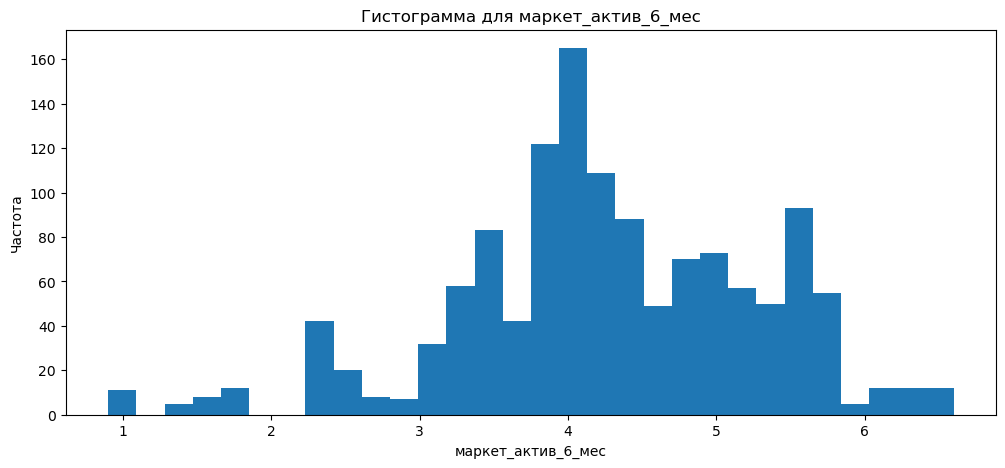

In [84]:
plot_data_visualization(market_file, 'маркет_актив_6_мес')

На бокслоте наблюдается 4 выброса, но не выглядит как аномалия, оставим данные значения

#### Количество маркетинговых коммуникаций

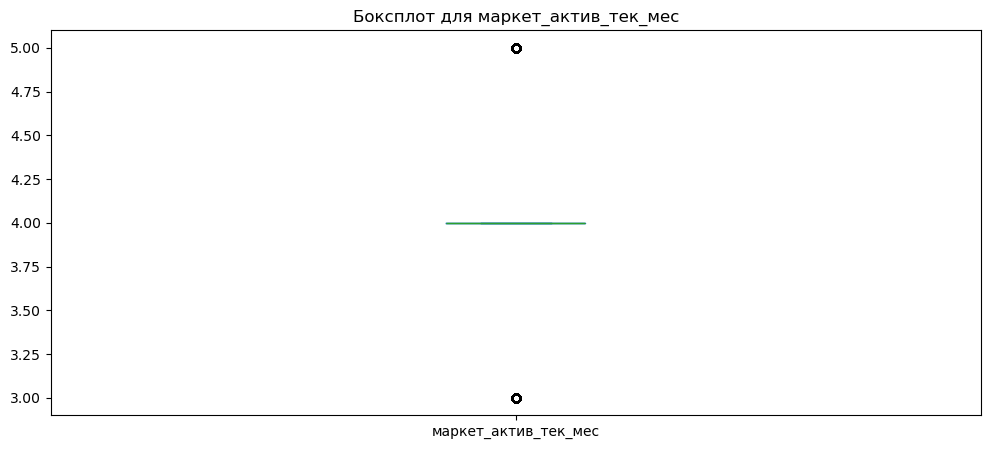

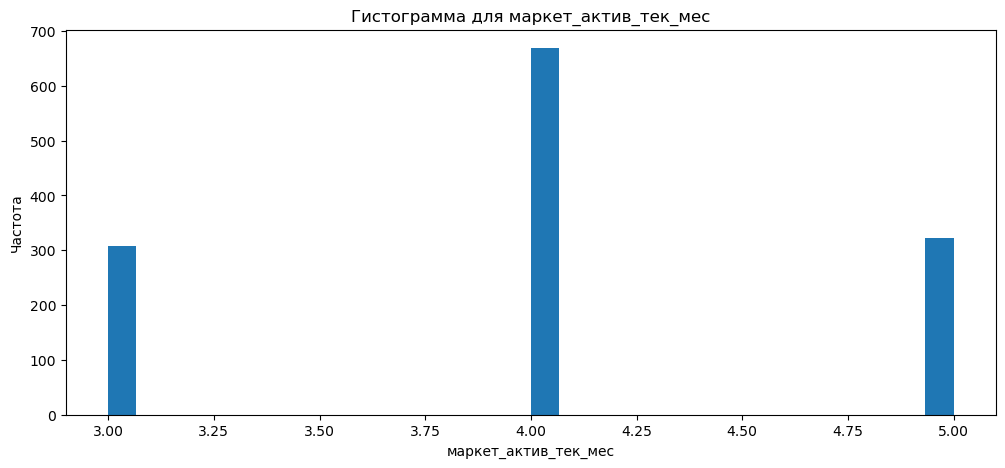

In [85]:
plot_data_visualization(market_file, 'маркет_актив_тек_мес')

Странная визуализация из-за того, что в столбце всего 3 уникальных значения 

#### Время с момента регистрации

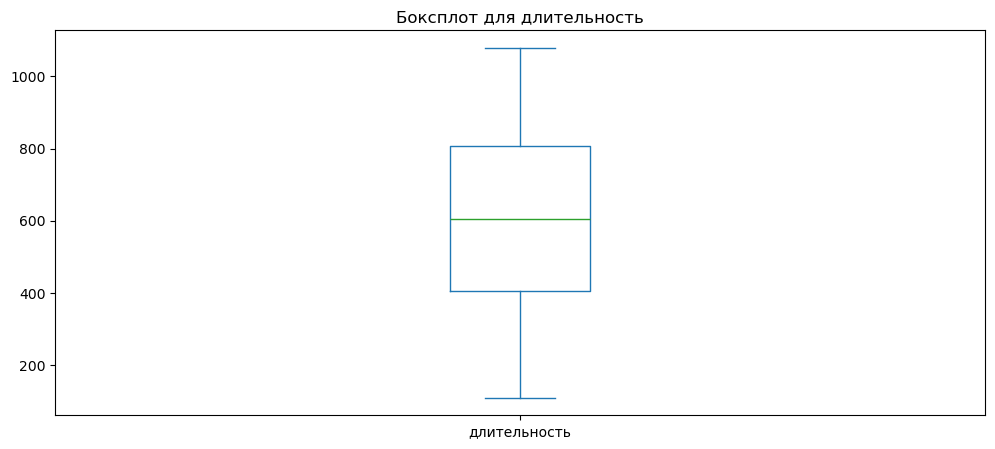

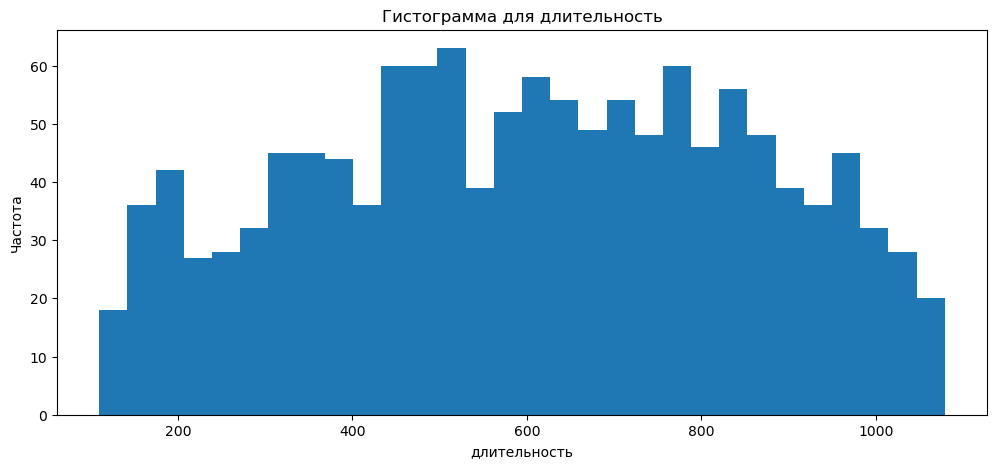

In [86]:
plot_data_visualization(market_file, 'длительность')

Проблем не обнаружено

#### Доля покупок по акции

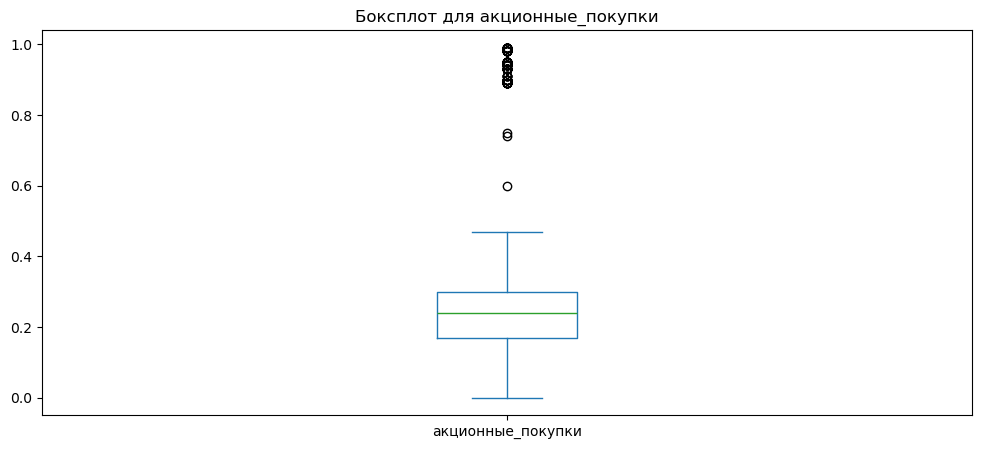

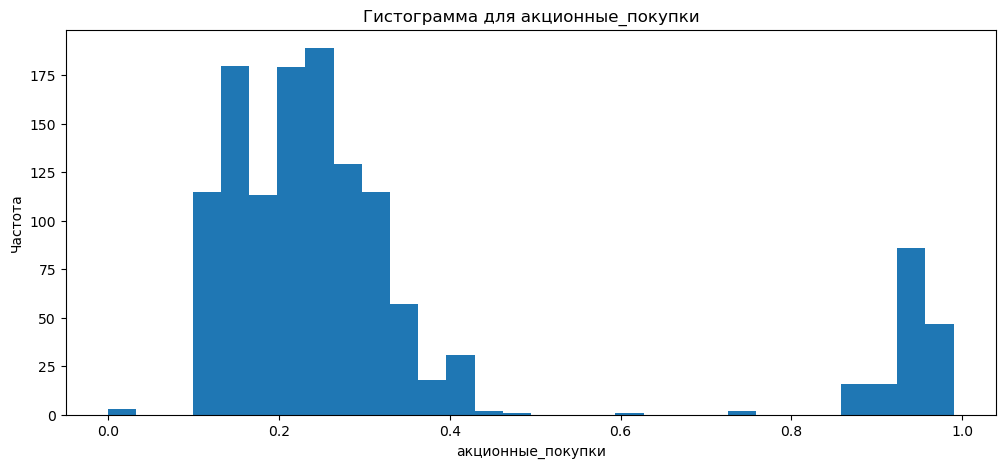

In [87]:
plot_data_visualization(market_file, 'акционные_покупки')

Видим 2 пика, преположим, что обусловлено людьми, которые очень любят акции, удалять такие выбросы не будем

#### Просмотры категорий в течении месяца

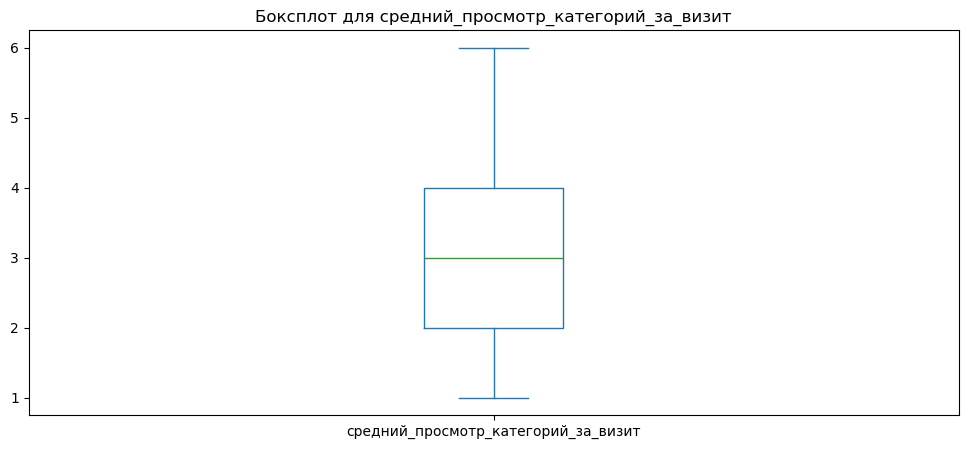

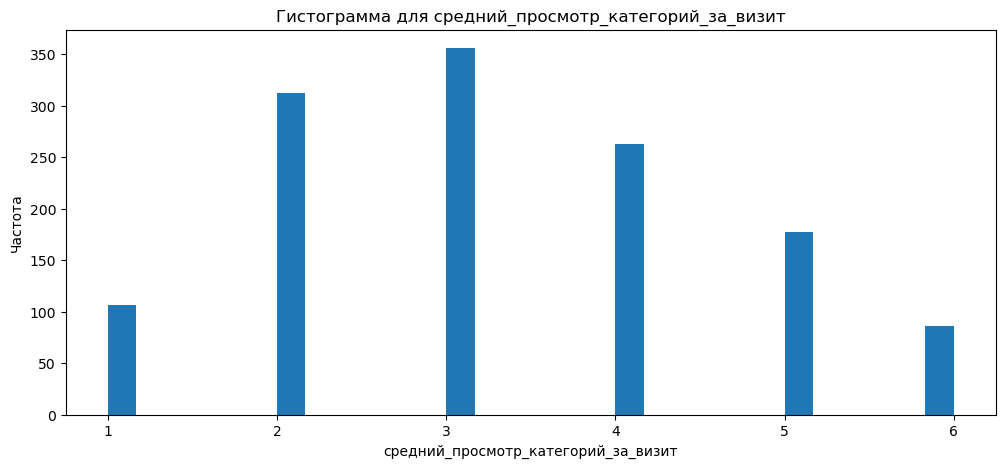

In [88]:
plot_data_visualization(market_file, 'средний_просмотр_категорий_за_визит')

Все отлично

#### Число неоплаченных товаров в корзине

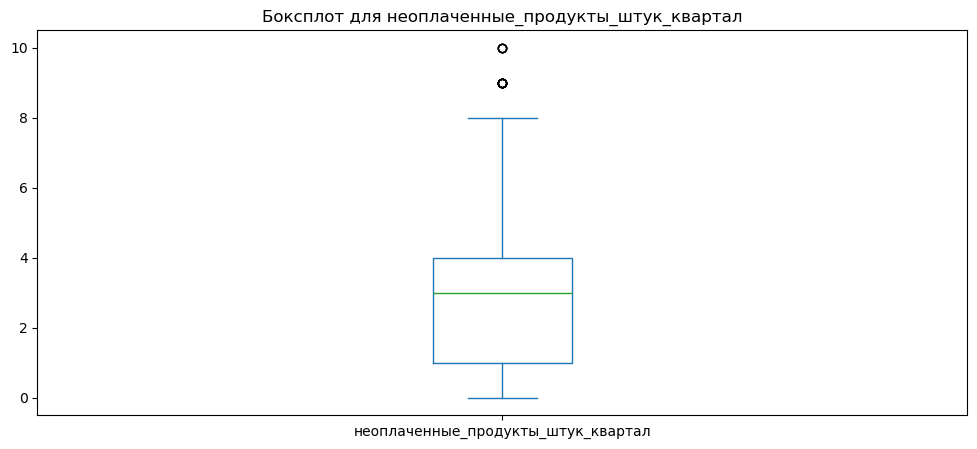

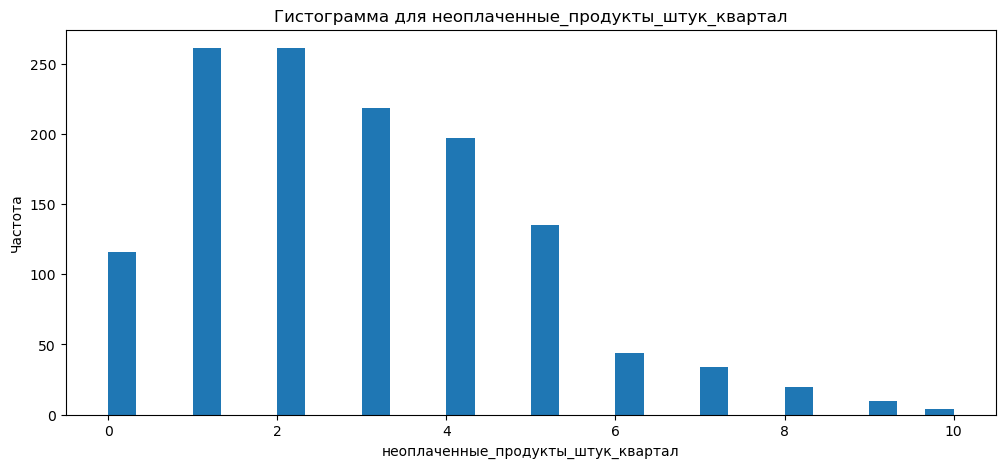

In [89]:
plot_data_visualization(market_file, 'неоплаченные_продукты_штук_квартал')

На боксплоте виднеются 2 выброса, не считаю их криминальными, оставим

#### Число сбоев сервиса

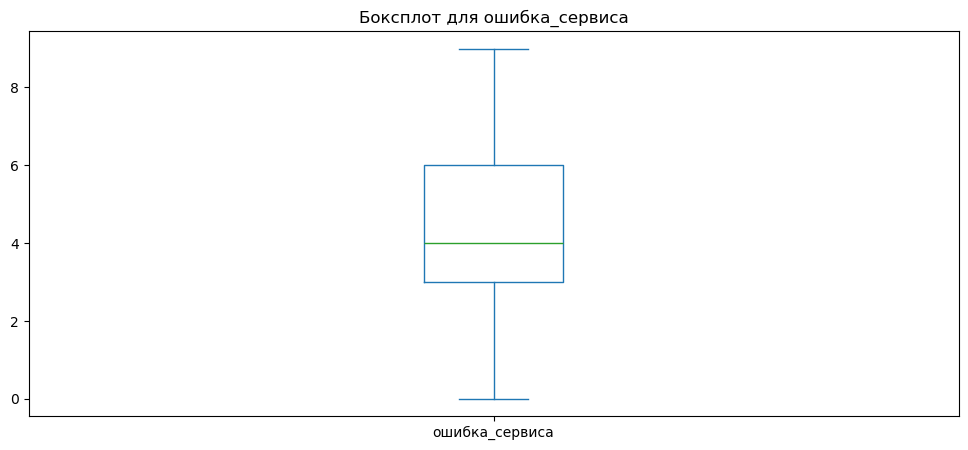

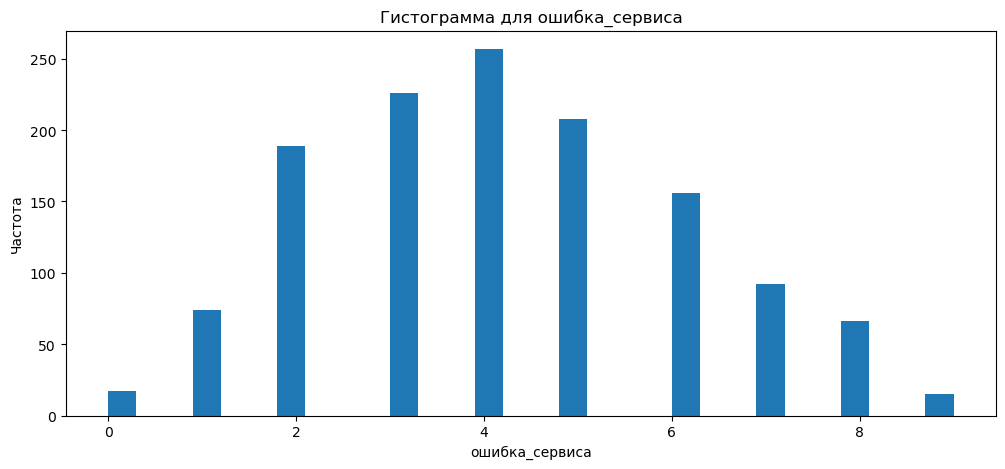

In [90]:
plot_data_visualization(market_file, 'ошибка_сервиса')

Претензий нет

#### Среднее количество страниц за визит

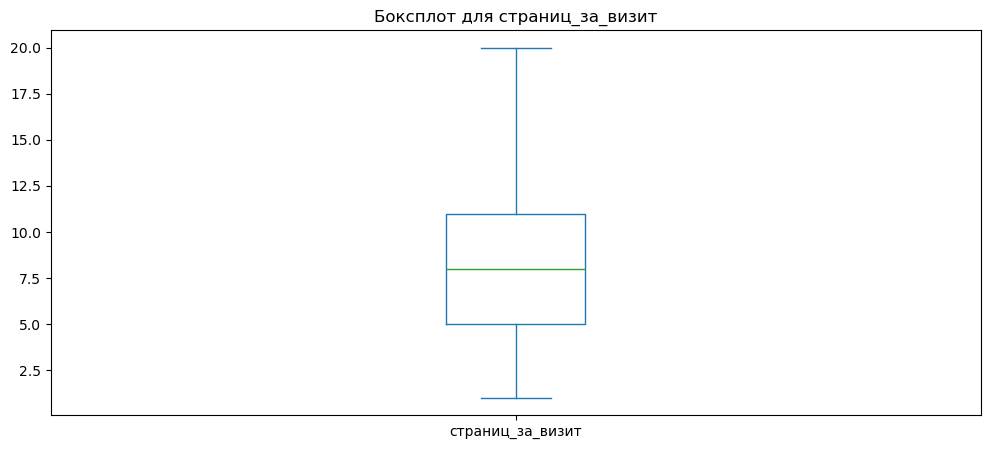

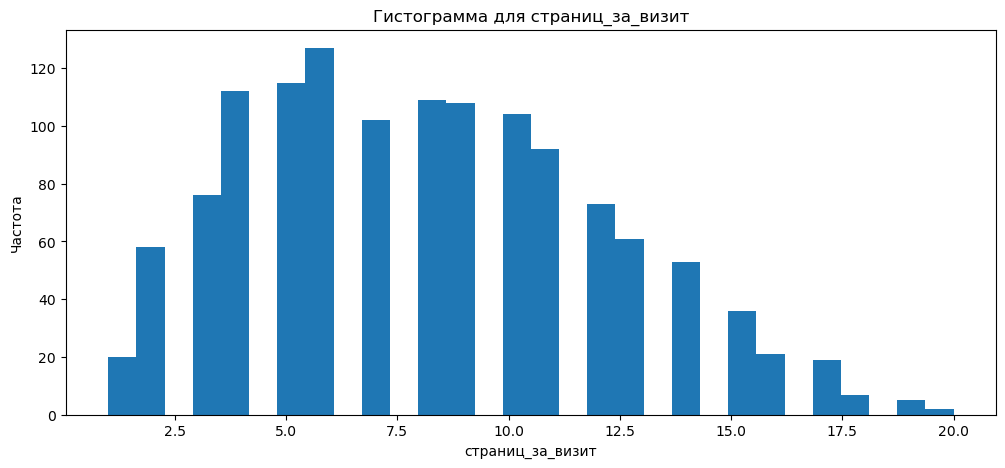

In [91]:
plot_data_visualization(market_file, 'страниц_за_визит')

Все в порядке 

#### Класс покупательской активности (целевой признак)

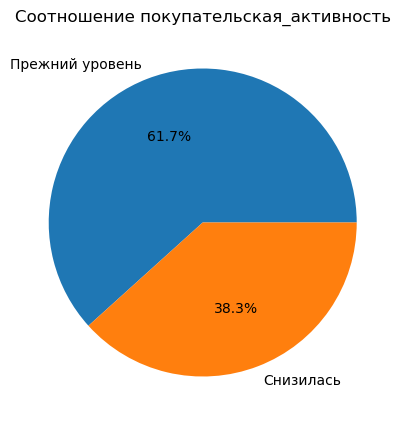

In [92]:
plot_data_visualization(market_file, 'покупательская_активность')

Возьмем на заметку, что наш целевой признак имеет небольшой дисбаланс 

#### Уровень подписки

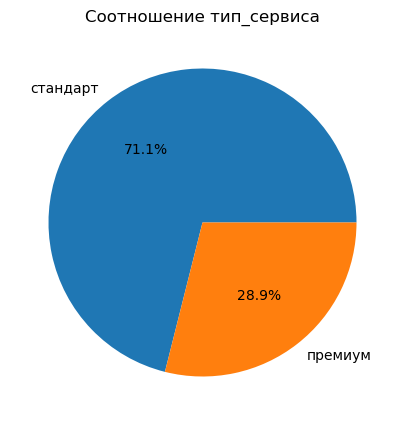

In [93]:
plot_data_visualization(market_file, 'тип_сервиса')

3\4 пользователей предпочитают пользоваться стандартной подпиской 

#### Информация о дополнительных рассылках

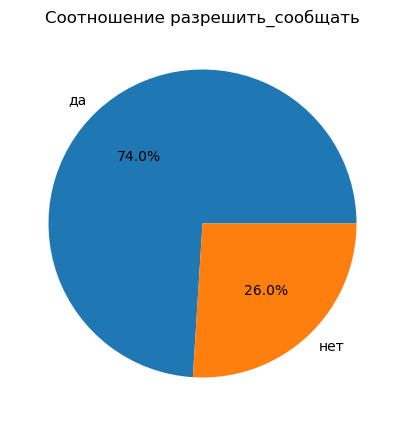

In [94]:
plot_data_visualization(market_file, 'разрешить_сообщать')

3\4 пользователей предпочитают получать дополнительную рассылку

#### Популярные категории

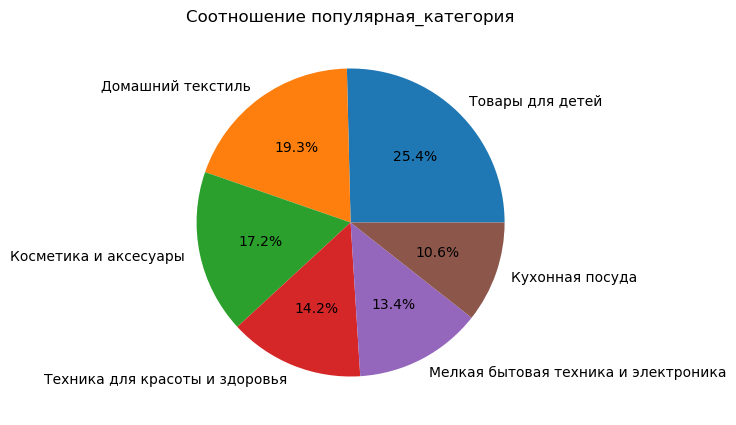

In [95]:
plot_data_visualization(market_file, 'популярная_категория')

Товары для детей являются самой популярной категорией, когда раздел с кухонной посудой менее 

### Исследование данных о выручке

In [96]:
explore_df(market_money)

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,id,выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


Бросается в глаза аномально большое значение в графе с выручкой, как и отсутствие ее

#### Название периода для выручки 

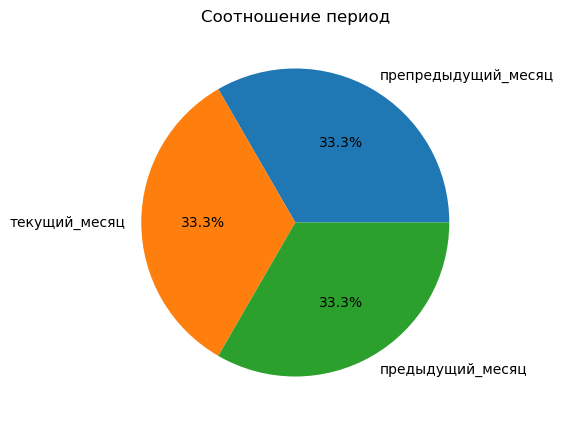

In [97]:
plot_data_visualization(market_money, 'период')

Идеально распределены данные по периодам, когда зафиксирована выручка

#### Сумма выручки

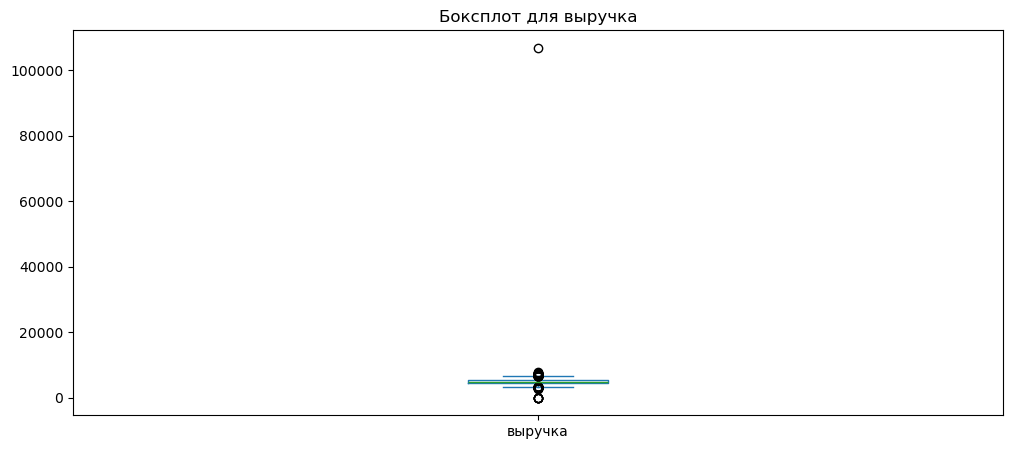

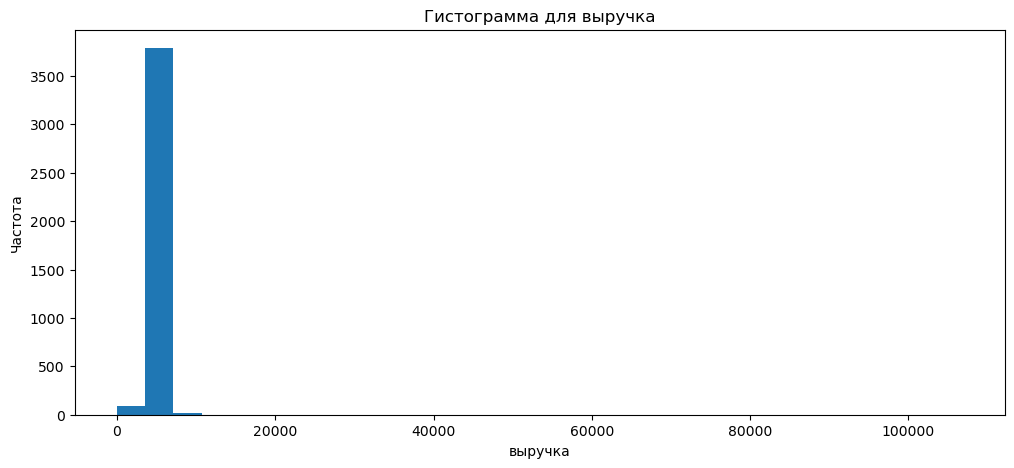

In [98]:
plot_data_visualization(market_money, 'выручка')

Убедились в аномалии, уберем невероятно большое и нулевые значения 

In [99]:
market_money = market_money[(market_money['выручка'] != 106862.2) & (market_money['выручка'] != 0)]

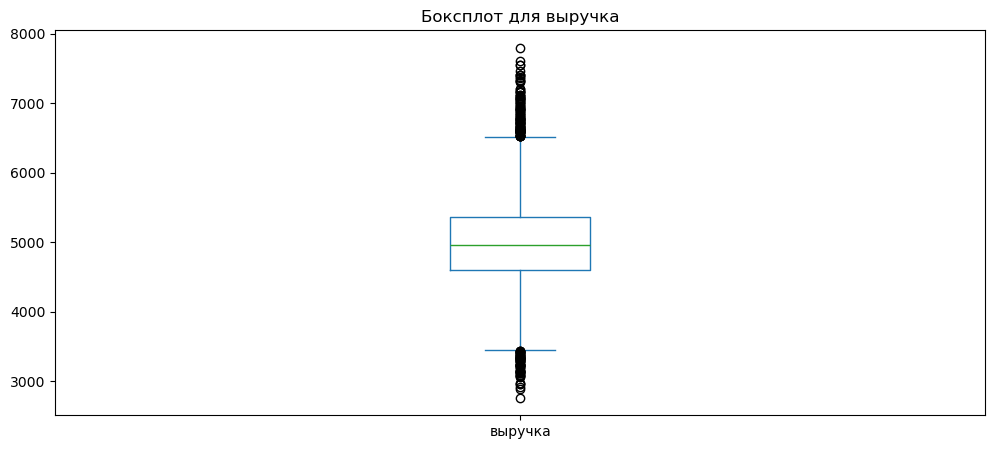

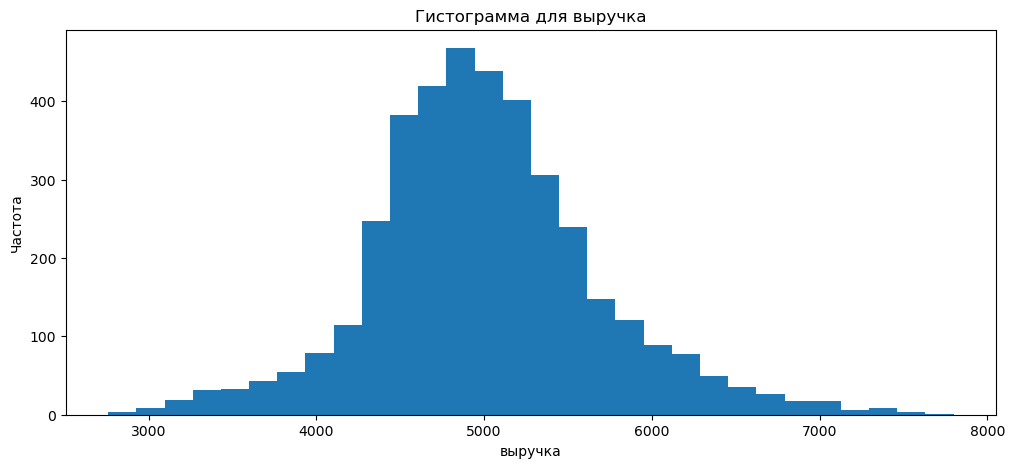

In [100]:
plot_data_visualization(market_money, 'выручка')

Теперь все в порядке, распределение на глаз очень похоже на нормальное

### Анализ времени на сайте 

In [101]:
explore_df(market_time)

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


На первый взгляд проблем с данными нет

#### Время, проведенное на сайте

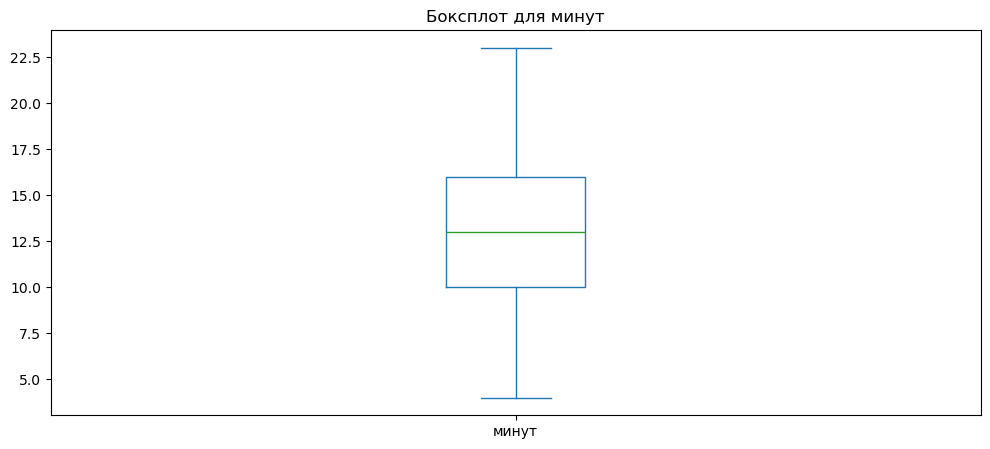

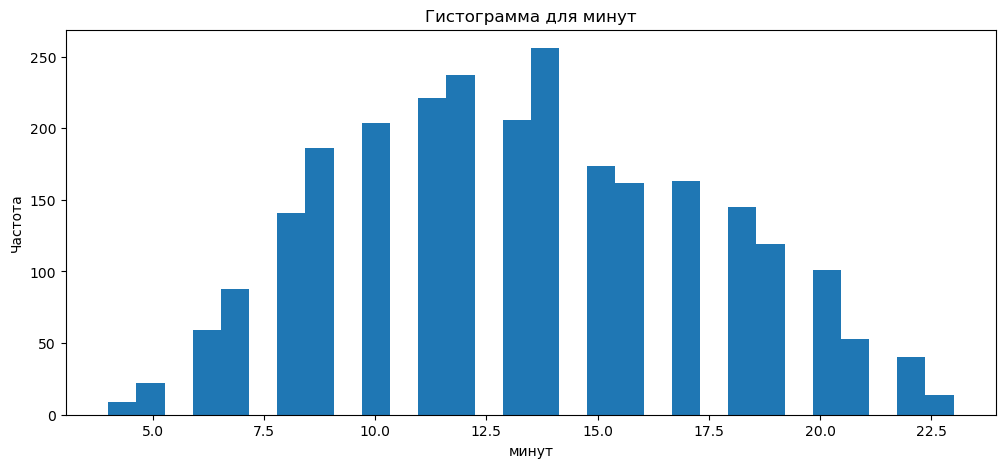

In [102]:
plot_data_visualization(market_time, 'минут')

Все в порядке

#### Названия периода о времени на сайте

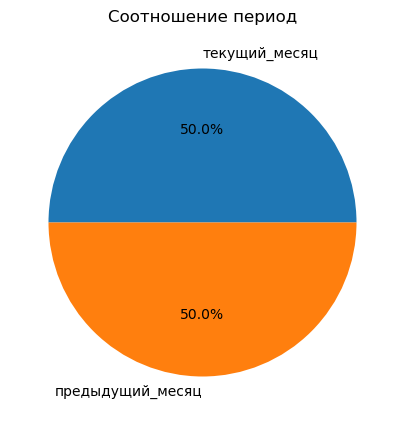

In [103]:
plot_data_visualization(market_time, 'период')

Идеально поделены 2 периода когда фиксировалось общее время 

### Исследование данных о прибыли за последние 3 месяца

In [104]:
explore_df(money)

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


#### Значение прибыли

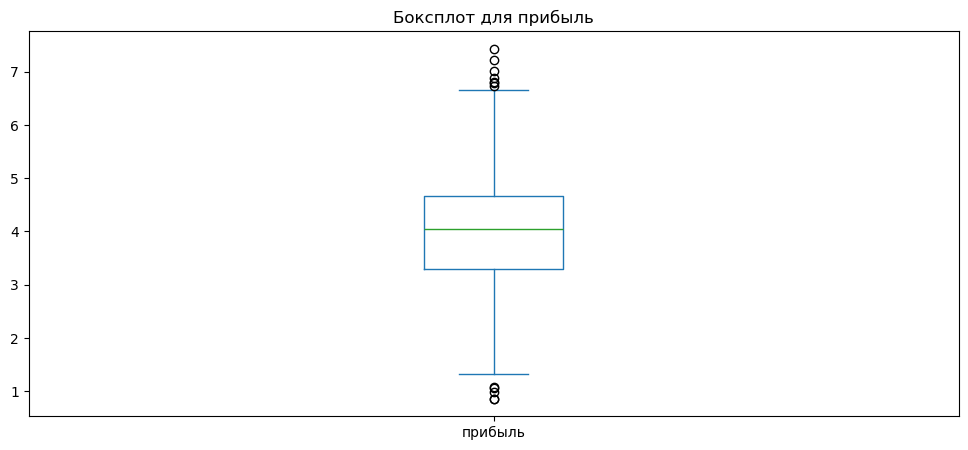

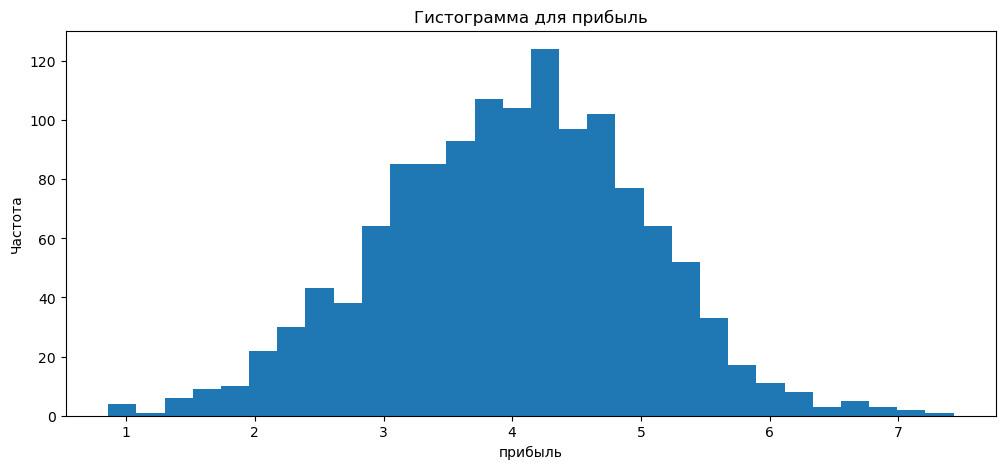

In [105]:
plot_data_visualization(money, 'прибыль')

Все хорошо, есть небольшие выбросы, но не выглядят критичными

## Объединения данных

In [106]:
#уточняем периоды для датафреймов
market_money = market_money.rename(columns={'период': 'период_выручка'})
market_time = market_time.rename(columns={'период': 'период_время'})

In [107]:
# Создаем pivot table для market_money
money_pivot = market_money.pivot_table(
    index='id',
    columns='период_выручка',
    values='выручка',
    aggfunc='sum')

# Создаем pivot table для market_time
time_pivot = market_time.pivot_table(
    index='id',
    columns='период_время',
    values='минут',
    aggfunc='sum')

In [108]:
#объедиянем датафреймы
df = market_file.merge(money_pivot, on='id')
df = df.merge(time_pivot, on='id')
df = df.set_index('id')

In [109]:
df.describe()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_x,препредыдущий_месяц,текущий_месяц_x,предыдущий_месяц_y,текущий_месяц_y
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000,1297.000000,1297.000000,1299.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923,4948.339630,4836.367772,5236.787452,13.467692,13.204615
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126,701.228571,333.438742,835.474686,3.932029,4.220589
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000,2890.000000,4098.000000,2758.700000,5.000000,4.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000,4498.500000,4585.000000,4705.500000,11.000000,10.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000,5005.500000,4812.000000,5179.600000,13.000000,13.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000,5409.000000,5055.000000,5759.950000,17.000000,16.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000,6869.500000,5663.000000,7799.400000,23.000000,23.000000


In [110]:
df.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_x,препредыдущий_месяц,текущий_месяц_x,предыдущий_месяц_y,текущий_месяц_y
id,,,,,,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,3293.1,13,14
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


In [111]:
df_info(df)

<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 215348 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1300 non-null   object 
 1   тип_сервиса                          1300 non-null   object 
 2   разрешить_сообщать                   1300 non-null   object 
 3   маркет_актив_6_мес                   1300 non-null   float64
 4   маркет_актив_тек_мес                 1300 non-null   int64  
 5   длительность                         1300 non-null   int64  
 6   акционные_покупки                    1300 non-null   float64
 7   популярная_категория                 1300 non-null   object 
 8   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 10  ошибка_сервиса                       1300 non-null   int64  
 11  страниц_за_визит            

In [112]:
#переименуем в более читаемый вид
df = df.rename(columns={
    "предыдущий_месяц_x": "выручка_предыдущий_месяц",
    "препредыдущий_месяц": "выручка_препредыдущий_месяц", 
    "текущий_месяц_x": "выручка_текущий_месяц",
    "предыдущий_месяц_y": "время_предыдущий_месяц",
    "текущий_месяц_y": "время_текущий_месяц"
})

#удалим дубли
df = df.drop_duplicates()

#удаляем пустые значения в выручке 
df = df.dropna(subset=['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц'])

Выводы по исследовательскому анализу: 
 - Проведен исследовательский анализ по каждому признаку
 - Данные не имеют нормального распределения
 - Удалено аномальное значение в ```market_money``` в столбце 'выручка'
 - В целевом признаке присутствует дисбаланс классов 
 - Объеденены датафреймы в один общий

## Корреляционный анализ

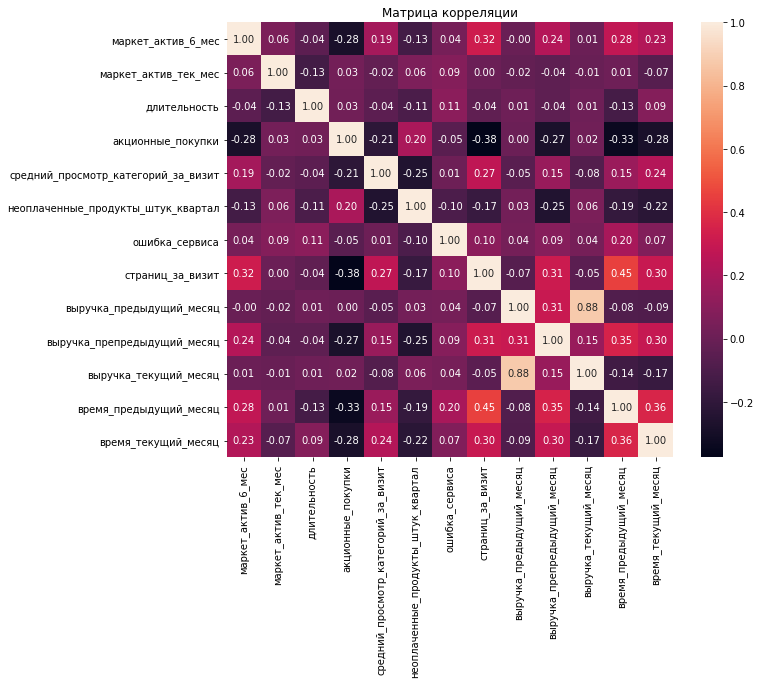

In [61]:
#строим матрицу корреляции для количественных признаков
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df.corr(method='spearman'), annot=True, fmt='.2f') 
plt.title("Матрица корреляции")
plt.show()

Выводы по корреляционному анализу:
 - Исследовательского анализа можно было заметить, что признаки не имеют танденций к нормальному распределению, то было решено использовать метор Спирмена
 - Мультиколлинеарность отсутствует

## Использование пайплайнов

In [113]:
#задаем параметры для деления на выборки
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['покупательская_активность'], axis=1),
    df['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df['покупательская_активность'])

#перепроверим 
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((963, 16), (322, 16), (963,), (322,))

In [114]:
df.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


ROC-AUC - метрика, которая используется в задачах бинарной классификации для оценки способности модели разграничивать классы, независимо от их соотношения (вспоминаем про дисбаланс классов в нашем целевом признаке). Поскольку задача связана с определением, снизилась ли покупательская активность или осталась на прежнем уровне - ROC-AUC будет оптимальной метрикой

In [116]:
#поделим показатели на количественные и качественные 
ohe_columns = ['популярная_категория', 'разрешить_сообщать']
ord_columns = ['тип_сервиса']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
               'акционные_покупки', 'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'выручка_предыдущий_месяц',
               'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'время_предыдущий_месяц',
               'время_текущий_месяц', 'страниц_за_визит']

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ])

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', OrdinalEncoder(), ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,9),
        'models__max_features': range(2,9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(probability=True)],
        'models__kernel': ['linear', 'rbf']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

#рассчитываем прогноз для тестовых данных
y_test_pred = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord', OrdinalEncoder(),
               

Вывод по созданию пайплайна:
 - Выбрана оптимальная метрика - ROC-AUC, т.к. она хорошо себя показывает при дисбалансе классов
 - Показания метрики для нашей модели очень хорошие = 0.92
 - Подобрана оптимальная можель для решения нашей задачи - LogisticRegression(C=2, penalty='l1', random_state=42,solver='liblinear')

## Анализ важности признаков

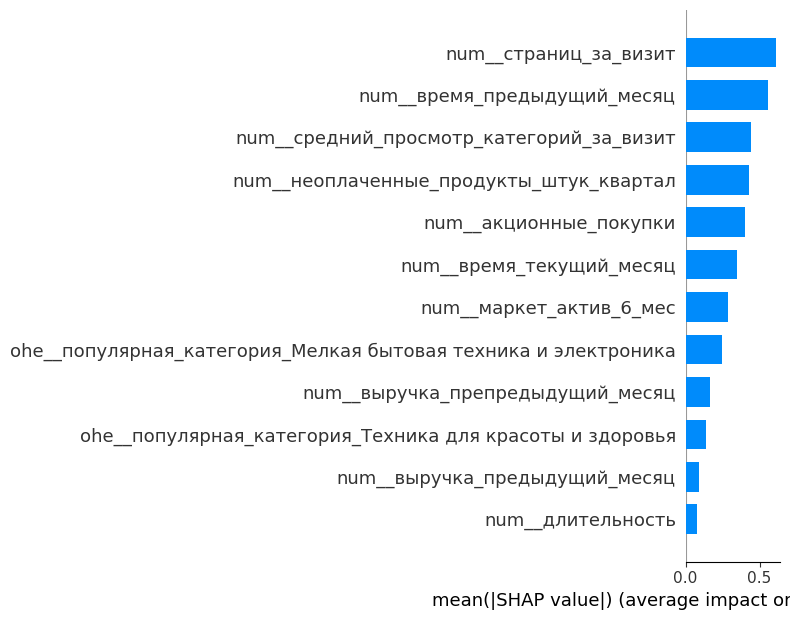

In [54]:
#тренируем модель
X_train_transformed = randomized_search.best_estimator_.named_steps['preprocessor'].fit_transform(X_train)
X_test_transformed = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test)

#создаем эксплейнер
explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'],
                                 X_train_transformed)
feature_names=randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
#рассчитываем значения
shap_values = explainer.shap_values(X_test_transformed)

#выведем график важности показателей
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, plot_type="bar", max_display=12)

Вывод по анализу важности:

с точки зрения модели наиболее важными признаком для прогноза активности:
  - Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца
  - Значение времени, проведённого на сайте за предыдущий месяц, в минутах
  - Средний просмотр категорий за визит
  

Наименее важными:
 - Показатели выручки за текущий месяц
 - Стандартный тип сервиса
 - Показатели выручки за прошлый месяц

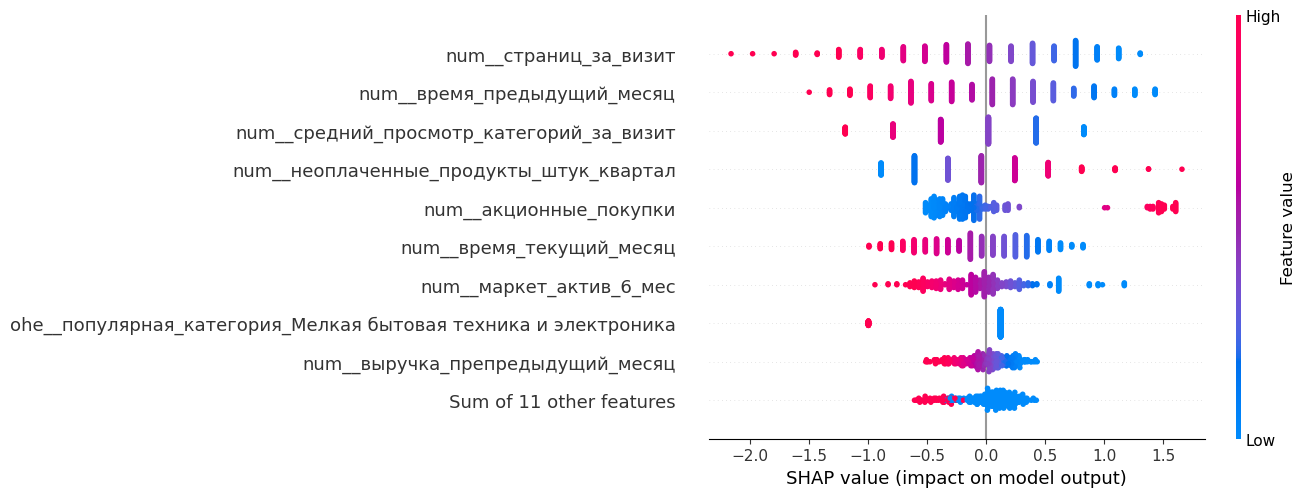

In [55]:
explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'], 
                           X_train_transformed, feature_names=feature_names)


shap_values = explainer(X_test_transformed)


shap.plots.beeswarm(shap_values)

## Сегментация покупателей

In [56]:
#применим лучшую модель на тестовой выборке и предскажем вероятности снижения покупательской способности
best_model = randomized_search.best_estimator_
predictions = best_model.predict_proba(X_test)
X_test['вероятность_снижения_активности'] = predictions[:, 1]

#соеденим с датафреймом о среднемесячной прибыли 
X_test= X_test.merge(money, on='id')

#установим порог в 60% вероятности того, что будет снижение покупательской способности 
X_test = X_test[X_test['вероятность_снижения_активности'] > 0.6]

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102 entries, 2 to 309
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   102 non-null    int64  
 1   тип_сервиса                          102 non-null    object 
 2   разрешить_сообщать                   102 non-null    object 
 3   маркет_актив_6_мес                   102 non-null    float64
 4   маркет_актив_тек_мес                 102 non-null    int64  
 5   длительность                         102 non-null    int64  
 6   акционные_покупки                    102 non-null    float64
 7   популярная_категория                 102 non-null    object 
 8   средний_просмотр_категорий_за_визит  102 non-null    int64  
 9   неоплаченные_продукты_штук_квартал   102 non-null    int64  
 10  ошибка_сервиса                       102 non-null    int64  
 11  страниц_за_визит                     

Далее перепроверим, что с увеличением вероятности, увеличивается и риск попасть в категории на снижение покупательной способности. Для наглядности применим модель на исходном датафрейме и потом сравним с количеством снизивших покупательную способность людей по факту

In [57]:
df_pred_test = df.drop(['покупательская_активность'], axis=1)

#применяем модель на исходном фрейме
predictions = best_model.predict_proba(df_pred_test)
df_pred_test['вероятность_снижения_активности'] = predictions[:, 1]

#поделим на сигменты в сторону потенциального увеличения рисков
probability_bins = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
df_pred_test['вероятность_снижения_кат'] = pd.cut(df_pred_test['вероятность_снижения_активности'], bins=probability_bins)

#вернем целевой признак для проверки
df_pred_test = df_pred_test.join(df['покупательская_активность'], on='id', how='left')

#на сводной таблице проверим тенденции
test = pd.pivot_table(
    df_pred_test,
    index='вероятность_снижения_кат',
    values='покупательская_активность',
    aggfunc='count')

print(f'Проверка тенденции: {test}')

Проверка тенденции:                           покупательская_активность
вероятность_снижения_кат                           
(0.5, 0.6]                                       30
(0.6, 0.7]                                       34
(0.7, 0.8]                                       51
(0.8, 0.9]                                       83
(0.9, 1.0]                                      226


Как видно - чем больше вероятность, тем выше количество пользователей, которые реально показали снижение покупательной активности

### Сегментация по прибыли

Выбираем сегмент на основе прибыли. С коммерческой состовляющей любая компания заинтересована, чтобы покупатели, приносящие бОльший доход не снижали свою покупательную способность

In [58]:
#Разделим выборку по прибыли на 3 части
pd.qcut(X_test['прибыль'], 3)

2       (4.587, 6.88]
11     (1.629, 3.723]
12     (3.723, 4.587]
20      (4.587, 6.88]
21     (1.629, 3.723]
            ...      
300    (1.629, 3.723]
301    (3.723, 4.587]
302    (1.629, 3.723]
304     (4.587, 6.88]
309    (3.723, 4.587]
Name: прибыль, Length: 102, dtype: category
Categories (3, interval[float64, right]): [(1.629, 3.723] < (3.723, 4.587] < (4.587, 6.88]]

In [59]:
high_profit_risk = X_test.query('прибыль > 4.587')
high_profit_risk.shape

(34, 19)

Можно выделить потенциально 34 клиента с высокой прибылью для компании, которые, согласно прогнозирующей модели имеют вероятность 60% и выше на снижение покупательной активности.

### Сегментация по категориям покупок

<Figure size 1200x600 with 0 Axes>

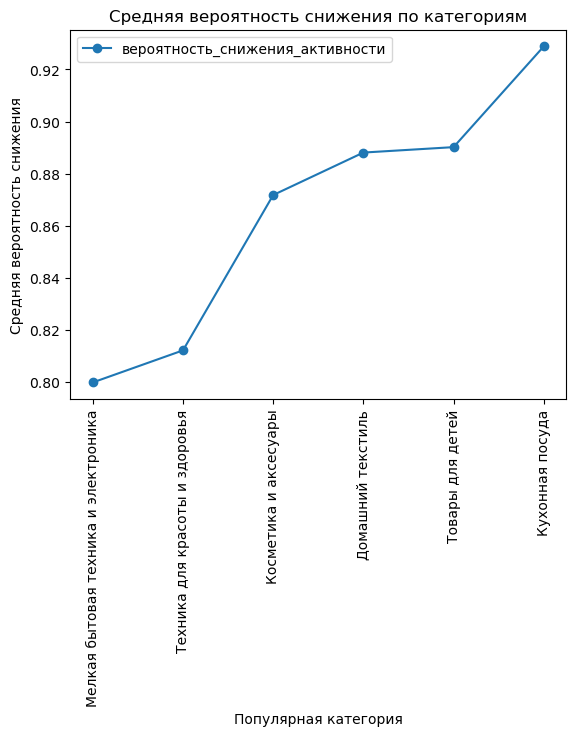

In [60]:
#сводная таблица для высокой вероятности снижения и типом покупок
category_avg_decline = X_test.groupby('популярная_категория')['вероятность_снижения_активности'].mean().reset_index()

#сортируем данные по возрастанию вероятности снижения
category_avg_decline = category_avg_decline.sort_values(by='вероятность_снижения_активности')

#посмотрим на распределение
plt.figure(figsize=(12, 6))
category_avg_decline.plot(x='популярная_категория', y='вероятность_снижения_активности', kind='line', marker='o')
plt.xlabel('Популярная категория')
plt.ylabel('Средняя вероятность снижения')
plt.title('Средняя вероятность снижения по категориям')
plt.xticks(rotation=90)
plt.show()

Пользователи, которые делают покупки в долгосрок и более серьезные из категории 'Мелкая бытовая техника и электроника' показывают лучшую устойчивость и реже понижают покупательную способность. Можно предложить бизнесу ввести новые акции и/или расширить ассортимент для привлечение внимания к этой категории. Когда товары покупки в разделе товаров для детей будут самими высокорисковыми. Стоит обратить внимание что есть в категории с техникой и что нет в данной.

<Figure size 1200x600 with 0 Axes>

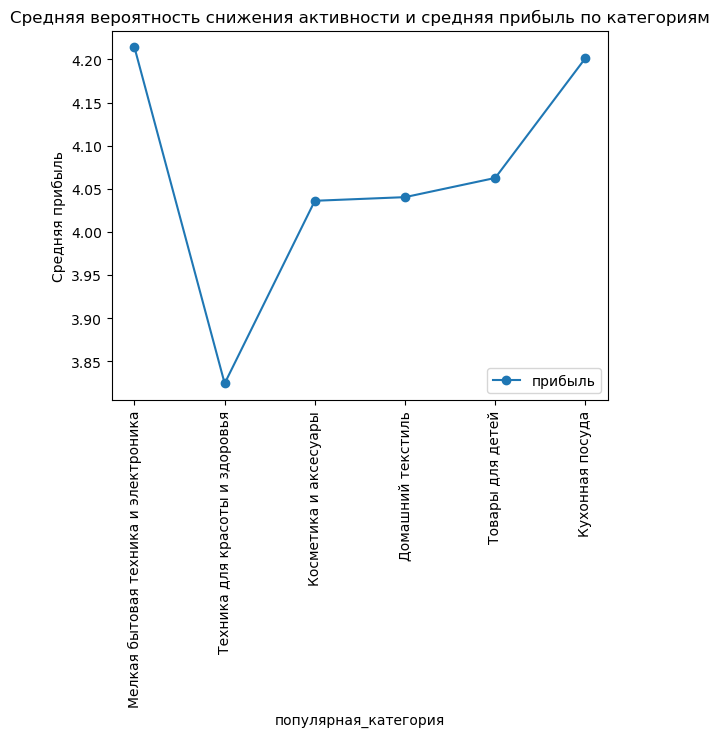

In [61]:
#повторим таблицу, но теперь включим прибыль
category_stats = X_test.groupby('популярная_категория')[['вероятность_снижения_активности', 'прибыль']].mean().reset_index()

#сортируем
category_stats = category_stats.sort_values(by='прибыль')


plt.figure(figsize=(12, 6))
category_stats = category_stats.sort_values(by='вероятность_снижения_активности')
category_stats.plot(x='популярная_категория', y='прибыль', kind='line', marker='o')
plt.xticks(rotation=90)
plt.ylabel('Средняя прибыль')
plt.title('Средняя вероятность снижения активности и средняя прибыль по категориям')
plt.show()

Как видим, большую прибыль приносят 'Мелкая бытовая техника' и 'Косметика и аксесуары'. Напомним, что техника еще и более устойчива к вероятности снижения покупательной способности - выделяем как лучшую категорию. Косметика и аксессуары показывают среднюю вероясть 

In [62]:
# Получаем данные для выбранной категории
category_data = X_test.query('популярная_категория in ["Мелкая бытовая техника и электроника", "Косметика и аксессуары", "Товары для детей"]')
# Создаем новый столбец, который показывает, чаще или реже пользуются акциями
category_data['акции_частота'] = category_data['акционные_покупки'].apply(lambda x: 'Чаще' if x > 0.5 else 'Реже')

# Создаем сводную таблицу с частотой использования акций по каждой категории
category_data = category_data.pivot_table(index='популярная_категория', 
                                                         columns='акции_частота', 
                                                         values='акционные_покупки', 
                                                         aggfunc='count')

category_data

C:\Users\User\AppData\Local\Temp\ipykernel_6788\1148415985.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_data['акции_частота'] = category_data['акционные_покупки'].apply(lambda x: 'Чаще' if x > 0.5 else 'Реже')


акции_частота,Реже,Чаще
популярная_категория,,
Мелкая бытовая техника и электроника,5.0,NaN
Товары для детей,16.0,14.0


Выборка небольшая, но в категории детских товаров соотношение тех, кто чаще и реже пользуются акциями почти равно, когда в категориях с техникой отсутствуют любители часто пользоваться акциями. Примечательно, что в косметика и аксессуарах вообще нет покупок по акции, может их и нет на эти товары в принципе. Хорошей идей будет попробовать ввести на данную категорию акции и смотреть тенденцию, учитывая, что данная категория приносит высокую прибыль. 

Вывод и рекомендации по сегментации:
 - Стоит ввести акции для категории косметики и аксессуаров как тестовую функцию и понаблюдать за результатом 
 - Люди, которые приобретают или задумываются и приобретении дорогостоящих товаров, в нашем случае техники, показывают меньшую вероятность снизить покупательную активность

## Общий вывод

Выполнены поставленные задачи для исследования: 

 - Разработана модель для предсказания вероятного снижения покупательской активности
 - Выделены сегменты покупателей и даны общие рекомендации
___

Для проведения исследования нам передали 4 датасета:
 - Данные об общем поведении покупателей, о коммуникациях с покупателем посредством сайта и его продуктовом поведении
 - Данными с выручкой, которую получает магазин с покупателя
 - Данными о времени (в минутах), которое покупатель провёл на сайте в течение периода
 - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца

Проведена предобработка датасетов: 
 - Удалены очевидные и неочевидные дубликаты 
 - Название стобцом приведены в змеиный регистр с оставленной кириллицей
 - Исправлены опечатки
 - Проверены датасеты на наличие пропусков и насколько оптимальные форматы у данных

В общем, датасеты предоставлены в хорошем качестве

___

 Чтобы найти лучшую модель для решения задачи была проведена преобработка данных; проведен исследовательский анализ и устранены аномалии; объединены датасеты в один; проведен коррелляционный численных показателей, мультиколлинеарность не обнаружена; с помощью пайплайна найдена лучшая модель для предсказания - LogisticRegression(C=2, penalty='l1', random_state=42,solver='liblinear'). Показатели нашей модели хорошие, метрика ROC-AUC = 0.92

___

Наиболее важными признаками, которые влияют на покупательную активности является:
  - Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца
  - Значение времени, проведённого на сайте, в минутах
  - Показатель акционных покупок
  
На основе этих данных можно дать **первую рекомендацию**: больше инвестировать в сайт и способы коммуникации с пользователями. Людям нравится пребывать на сайте, искать товары для себя, перебирать категории. Возможно, улучшении интерфейса сайта, оптимизация для всех устройств и бесперебойность дадут ощутимый вклад в увеличение показателей покупательской активности

В рамках исследования также были проведены деления на сегментации из которых следует **вторая рекомендация**: попробовать уделить больше внимания новым акциям и привлечением людей ими пользоваться, особенно для категории Косметики и аксессуаров. Бытовая техника и элетроника, которых можно назвать серьезными покупками показывают меньшую вероятность снижения покупательской активности, стоит уделить внимание этому разделу и регулярно его обновлять

Модель уже способна предсказать потенциальное снижение покупательной активности у сегмента пользователей, приносящие наибольшую прибыль (34 покупателя минимум)